In [1]:
# Import the packages needed
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import io

# **3. Data imputation**

In [2]:
!pip install miceforest==2.0.4
import miceforest as mf
import math
!pip install autoimpute
from autoimpute.imputations import MultipleImputer

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=a88983e077332c9e15a69568a8e0283a10cd94279446ecfc32330200b7caee70
  Stored in directory: c:\users\kaiwe\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529958 sha256=ecfde2fb3c28911c1c8ccd7e4b63f1a3c06312b37059789817dee90c24ebd2ce
  Stored in directory: c:\users\kaiwe\appdata\local\pip\cache\wheels\0e\41\d2\82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df2 = pd.read_csv("Feature_selected.csv")
df2.head()

AGE  ALT_BLOOD  AST_BLOOD  B_BLOK_S_n  DLIT_AG  D_AD_ORIT  FIB_G_POST  \
0  77.0        NaN        NaN         0.0      7.0      100.0         0.0   
1  55.0       0.38       0.18         0.0      0.0       90.0         0.0   
2  52.0       0.30       0.11         1.0      2.0      100.0         0.0   
3  68.0       0.75       0.37         0.0      3.0       70.0         0.0   
4  60.0       0.45       0.22         0.0      7.0       90.0         0.0   

   FK_STENOK   GB  GIPER_NA  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
0        1.0  3.0       0.0  ...          0           0         0          0   
1        0.0  0.0       0.0  ...          0           0         0          0   
2        0.0  2.0       0.0  ...          0           0         0          0   
3        0.0  2.0       0.0  ...          0           0         0          0   
4        0.0  3.0       0.0  ...          0           0         0          0   

   RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0       0         0    0       0          0       0  
1       0         0    0       0          0       0  
2       0         0    0       0          0       0  
3       0         0    1       0          0       0  
4       0         0    0       0          0       0  

[5 rows x 69 columns]

###  (1) Multiple Imputation by Chained Equations (MICE)

In [4]:
# Only impute with feature columns + labels and without ID
X = df2.copy()

# Create kernel
kernel = mf.MultipleImputedKernel(
  X,
  datasets=5,
  save_all_iterations=True)

# Run the MICE algorithm for 5 iterations on each of the datasets
kernel.mice(5)

In [5]:
# Multiple datasets are typically created so that some measure of confidence around each prediction can be created.
print(kernel)

              Class: MultipleImputedKernel
       Models Saved: Last Iteration
           Datasets: 5
         Iterations: 5
  Imputed Variables: 56
save_all_iterations: True


In [6]:
dataset_1 = kernel.complete_data(0) # get the first imputed dataset

# the dataset now has no missing values
print("Total percent of missing values:", dataset_1.isnull().sum().sum()/len(dataset_1))

Total percent of missing values: 0.0


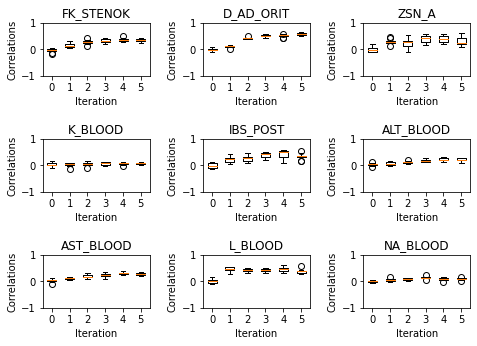

In [7]:
# Check for convergence of imputed values
variables = ["FK_STENOK", "D_AD_ORIT", "ZSN_A", "K_BLOOD", "IBS_POST", "ALT_BLOOD", "AST_BLOOD", "L_BLOOD", "NA_BLOOD"]
kernel.plot_correlations(variables=variables, left=0.001, right=0.99, bottom = 0.001, top = 0.99, wspace=0.5, hspace=1.2)

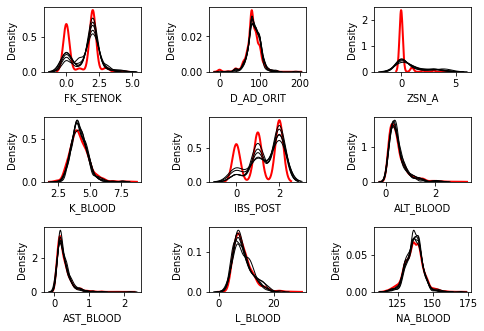

In [8]:
# Plot distributions of imputed values, red are the original values
kernel.plot_imputed_distributions(variables=variables, left=0.001, right=0.99, bottom = 0.001, top = 0.99, wspace=0.7, hspace=0.7)

In [12]:
dataset_1 = kernel.complete_data(0) # get the first imputed dataset
dataset_2 = kernel.complete_data(1) # get the second imputed dataset
dataset_3 = kernel.complete_data(2) # get the third imputed dataset
dataset_4 = kernel.complete_data(3) # get the fourth imputed dataset
dataset_5 = kernel.complete_data(4) # get the fifth imputed dataset

### (2) Predictive Mean Matching (PMM)

In [9]:
# Now impute using mean matching (PMM)
kernelmeanmatch = mf.MultipleImputedKernel(X, mean_match_candidates=5)
kernelmeanmatch.mice(5)

In [10]:
datasetPMM_1 = kernelmeanmatch.complete_data(0) # get the first PMM imputed dataset

# the dataset now has no missing values
print("Total percent of missing values:", datasetPMM_1.isnull().sum().sum()/len(datasetPMM_1))

Total percent of missing values: 0.0


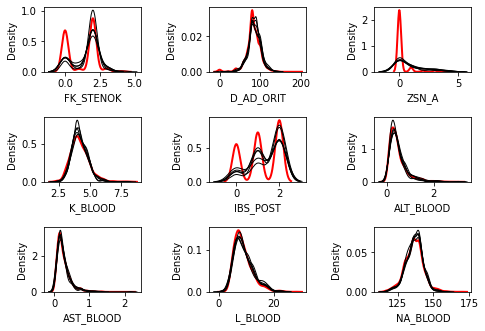

In [11]:
# Plot distributions of imputed values, red are the original values
variables = ["FK_STENOK", "D_AD_ORIT", "ZSN_A", "K_BLOOD", "IBS_POST", "ALT_BLOOD", "AST_BLOOD", "L_BLOOD", "NA_BLOOD"]
kernelmeanmatch.plot_imputed_distributions(variables=variables, left=0.001, right=0.99, bottom = 0.001, top = 0.99, wspace=0.7, hspace=0.7)

In [13]:
datasetPMM_1 = kernelmeanmatch.complete_data(0) # get the first PMM imputed dataset
datasetPMM_2 = kernelmeanmatch.complete_data(1) # get the second PMM imputed dataset
datasetPMM_3 = kernelmeanmatch.complete_data(2) # get the third PMM imputed dataset
datasetPMM_4 = kernelmeanmatch.complete_data(3) # get the fourth PMM imputed dataset
datasetPMM_5 = kernelmeanmatch.complete_data(4) # get the fifth PMM imputed dataset

In [14]:
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, X, datasetPMM_1, datasetPMM_2, datasetPMM_3, datasetPMM_4, datasetPMM_5]
from scipy import stats

p_value = 0.05
p = np.zeros((len(datasets), len(X.columns)))
test = np.zeros((len(datasets), len(X.columns), 2))
means = np.zeros((len(datasets), len(X.columns)))
stdevs = np.zeros((len(datasets), len(X.columns)))
rejected = 0

def plot_original_and_imputed_data(df_original, df_imputed, col_1, col_2):
    missing=df_original[col_2].isnull()
    plt.scatter(df_original[col_1], df_original[col_2], color='gray')
    plt.scatter(df_imputed[col_1][missing], df_imputed[col_2][missing], color='royalblue')
    plt.xlabel(str(col_1))
    plt.ylabel(str(col_2))
    plt.show()

# Red is the original, black is the imputed data
def plot_original_and_imputed_density_9 (df_original, df_imputed, var):
    f, axes = plt.subplots(3, 3, figsize=(7, 7))
    count=0
    for i in range(3):
        for j in range(3):
            sns.kdeplot(df_original[var[count]], color="red", ax=axes[i, j])
            sns.kdeplot(df_imputed[var[count]], color="black", ax=axes[i, j])
            count+=1
    plt.tight_layout()

### (3) Mean/Mode

In [15]:
OUTCOME = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS"]
FEATURES = list(set(list(df2.columns)).difference(set(OUTCOME)))

In [16]:
df4=df2.loc[:, FEATURES]

# Do mean for numeric columns and mode for the rest
Column_Mean=['AGE','S_AD_ORIT','D_AD_ORIT','K_BLOOD','NA_BLOOD','ALT_BLOOD','AST_BLOOD',
             'L_BLOOD','ROE']
No_Need=['ID','SEX']
Column_Mode=set(list(df4.columns)).difference(set(Column_Mean)).difference(set(No_Need))

for (columnName, columnData) in df4.iteritems(): 
    if columnName in Column_Mean:
        mean=df4[columnName].mean()
        df4.fillna(value={columnName: mean}, inplace=True)
    if columnName in Column_Mode:
        mode=float(df4[columnName].mode())
        df4.fillna(value={columnName: mode}, inplace=True)

# the dataset now has no missing values
print("Total percent of missing values:", df4.isnull().sum().sum()/len(df4))

# Add labels back to df4
df4 = pd.concat([df4, df2[OUTCOME]], axis = 1)

Total percent of missing values: 0.0


### (4) Regression Imputation

In [17]:
df5 = df2.loc[:, FEATURES]
# Correlation matrix showing how the features are related to each other
corr=df5.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [18]:
# Lists of data column names for the creation of subsets
Numerical=['AGE','S_AD_ORIT','D_AD_ORIT','K_BLOOD','NA_BLOOD','ALT_BLOOD','AST_BLOOD','L_BLOOD','ROE']
No_Need=['SEX']
Ordinal=['INF_ANAM','STENOK_AN','FK_STENOK','IBS_POST','GB','DLIT_AG','ZSN_A','ant_im',
         'lat_im','inf_im','post_im','TIME_B_S','R_AB_1_n','NA_R_1_n','NOT_NA_1_n',
         'R_AB_2_n','NA_R_2_n','NOT_NA_2_n','R_AB_3_n','NA_R_3_n'] #,'NOT_NA_3_n'

Binary=list(set(list(df5.columns)).difference(set(Numerical)).difference(set(No_Need)).difference(set(Ordinal)))
print(len(Binary))

27


In [19]:
# Create data subsets for data imputaion of different data types
test_nu = df5[Numerical]
test_or = df5[Ordinal]
test_bi = df5[Binary]

# Data distribution in binary features
test_bi.apply(pd.Series.value_counts)

n_r_ecg_p_09  MP_TP_POST  ritm_ecg_p_04  ritm_ecg_p_07  ritm_ecg_p_06  \
0.0          1583        1572           1525           1195           1547   
1.0             2         114             23            353              1   

     n_r_ecg_p_01  nr_11  n_r_ecg_p_08  zab_leg_02  O_L_POST  ...  FIB_G_POST  \
0.0          1527   1637          1581        1572      1578  ...        1673   
1.0            58     42             4         121       110  ...          15   

     fibr_ter_07  GIPER_NA  n_p_ecg_p_12  fibr_ter_08  fibr_ter_01  \
0.0         1684      1295          1507         1688         1677   
1.0            6        30            78            2           13   

     SIM_GIPERT  endocr_01  nr_03  LID_S_n  
0.0        1635       1461   1644     1211  
1.0          57        228     35      479  

[2 rows x 27 columns]

In [20]:
# Make 1/7 of NaN 1 because of the sheer class imbalance for some features preventing logistic regression
import warnings
warnings.filterwarnings("ignore")
for i in Binary:
    test_bi[i] = test_bi[i].fillna(1, limit = math.ceil((1/7)*test_bi[i].isna().sum()))

test_bi.apply(pd.Series.value_counts)

n_r_ecg_p_09  MP_TP_POST  ritm_ecg_p_04  ritm_ecg_p_07  ritm_ecg_p_06  \
0.0          1583        1572           1525           1195           1547   
1.0            19         116             45            375             23   

     n_r_ecg_p_01  nr_11  n_r_ecg_p_08  zab_leg_02  O_L_POST  ...  FIB_G_POST  \
0.0          1527   1637          1581        1572      1578  ...        1673   
1.0            75     45            21         122       112  ...          17   

     fibr_ter_07  GIPER_NA  n_p_ecg_p_12  fibr_ter_08  fibr_ter_01  \
0.0         1684      1295          1507         1688         1677   
1.0            8        84            95            4           15   

     SIM_GIPERT  endocr_01  nr_03  LID_S_n  
0.0        1635       1461   1644     1211  
1.0          59        230     38      481  

[2 rows x 27 columns]

In [21]:
# Data imputation for binary features
BI = MultipleImputer(n=5, strategy="binary logistic", return_list=True).fit_transform(test_bi)
df_BI = pd.DataFrame(BI)
df_BI1 = pd.DataFrame(BI[0][1])
df_BI2 = pd.DataFrame(BI[1][1])
df_BI3 = pd.DataFrame(BI[2][1])
df_BI4 = pd.DataFrame(BI[3][1])
df_BI5 = pd.DataFrame(BI[4][1])

# Data imputation for numeric features
ST = MultipleImputer(n=5, strategy='stochastic',return_list=True).fit_transform(test_nu)
df_ST = pd.DataFrame(ST)
df_ST1 = pd.DataFrame(ST[0][1])
df_ST2 = pd.DataFrame(ST[1][1])
df_ST3 = pd.DataFrame(ST[2][1])
df_ST4 = pd.DataFrame(ST[3][1])
df_ST5 = pd.DataFrame(ST[4][1])

In [22]:
# Data imputation for ordinal features
MU = MultipleImputer(n=5, strategy="multinomial logistic", return_list=True).fit_transform(test_or)
df_MU = pd.DataFrame(MU)
df_MU1 = pd.DataFrame(MU[0][1])
df_MU2 = pd.DataFrame(MU[1][1])
df_MU3 = pd.DataFrame(MU[2][1])
df_MU4 = pd.DataFrame(MU[3][1])
df_MU5 = pd.DataFrame(MU[4][1])

In [23]:
stoch_ft1 = pd.concat([df2['SEX'], df_BI1, df_MU1, df_ST1, df2[OUTCOME]], axis = 1)
stoch_ft2 = pd.concat([df2['SEX'], df2[OUTCOME], df_BI2, df_MU2, df_ST2], axis = 1)
stoch_ft3 = pd.concat([df2['SEX'], df2[OUTCOME], df_BI3, df_MU3, df_ST3], axis = 1)
stoch_ft4 = pd.concat([df2['SEX'], df2[OUTCOME], df_BI4, df_MU4, df_ST4], axis = 1)
stoch_ft5 = pd.concat([df2['SEX'], df2[OUTCOME], df_BI5, df_MU5, df_ST5], axis = 1)

### (5) K-Nearest Neighbour (KNN) Imputation

In [24]:
### Define function for KNN imputation ####
# Refernece: https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850
# Reference: https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

#del all

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers

def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [25]:
df6=df5.copy()

# Lists of data column names for the creation of data subsets
Numerical=['AGE','S_AD_ORIT','D_AD_ORIT','K_BLOOD','NA_BLOOD','ALT_BLOOD','AST_BLOOD','L_BLOOD','ROE']
No_Need=['SEX']
Ordinal=['INF_ANAM','STENOK_AN','FK_STENOK','IBS_POST','GB','DLIT_AG','ZSN_A','ant_im',
         'lat_im','inf_im','post_im','TIME_B_S','R_AB_1_n','NA_R_1_n','NOT_NA_1_n',
         'R_AB_2_n','NA_R_2_n','NOT_NA_2_n','R_AB_3_n','NA_R_3_n']
Binary=list(set(list(df6.columns)).difference(set(Numerical)).difference(set(No_Need)).difference(set(Ordinal)))

# Create data subsets for data imputaion of different data types
df_nu = df6[Numerical]
df_cat = df6[Ordinal+list(Binary)]

In [26]:
# Create first dataframe for imputed data columns to be appended (column "SEX" + ordinal/binary columns)
DF_cat = df6[['SEX']]

# Impute columns of ordinal/binary values with mode and hamming distance
for (columnName, columnData) in df_cat.iteritems():
    new_df = knn_impute(target=df_cat[columnName], attributes=df_cat.drop([columnName], 1),
                                    aggregation_method="mode", k_neighbors=5, numeric_distance='euclidean', categorical_distance='hamming', missing_neighbors_threshold=1.1)
    DF_cat = pd.concat([DF_cat, new_df], axis=1)
    
# The dataset now has no missing values
print("Total percent of missing values:", DF_cat.isnull().sum().sum()/len(DF_cat))

Total percent of missing values: 0.0


In [27]:
# Create second dataframe for imputed data columns to be appended (numeric columns)
DF_nu = pd.DataFrame()

# Impute columns of numeric values with mean and euclidean distance
for (columnName, columnData) in df_nu.iteritems():
    new_df = knn_impute(target=df_nu[columnName], attributes=df_nu.drop([columnName], 1),
                                    aggregation_method="mean", k_neighbors=5, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=1.1)
    DF_nu = pd.concat([DF_nu, new_df], axis=1)
    
# The dataset now has no missing values
print("Total percent of missing values:", DF_nu.isnull().sum().sum()/len(DF_nu))

Total percent of missing values: 0.0


In [28]:
# Concatenate the two subsets
df_KNN = pd.concat([DF_cat, DF_nu, df2[OUTCOME]], axis=1)

### (6) Compare performances

In [29]:
stoch_ft1.head()

SEX  n_r_ecg_p_09  MP_TP_POST  ritm_ecg_p_04  ritm_ecg_p_07  ritm_ecg_p_06  \
0    1           0.0         0.0            0.0            1.0            0.0   
1    1           0.0         0.0            0.0            0.0            0.0   
2    1           0.0         0.0            0.0            0.0            0.0   
3    0           0.0         0.0            0.0            0.0            0.0   
4    1           0.0         0.0            0.0            1.0            0.0   

   n_r_ecg_p_01  nr_11  n_r_ecg_p_08  zab_leg_02  ...  JELUD_TAH  FIBR_JELUD  \
0           0.0    0.0           0.0         0.0  ...          0           0   
1           0.0    0.0           0.0         0.0  ...          0           0   
2           0.0    0.0           0.0         0.0  ...          0           0   
3           0.0    0.0           0.0         0.0  ...          0           0   
4           0.0    0.0           0.0         0.0  ...          0           0   

   A_V_BLOK  OTEK_LANC  RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0         0          0       0         0    0       0          0       0  
1         0          0       0         0    0       0          0       0  
2         0          0       0         0    0       0          0       0  
3         0          0       0         0    1       0          0       0  
4         0          0       0         0    0       0          0       0  

[5 rows x 69 columns]

In [30]:
datasetkNN = df_KNN
datasetMM_1 = df4
datasetSTOCH1 = stoch_ft1
datasetSTOCH2 = stoch_ft2
datasetSTOCH3 = stoch_ft3 
datasetSTOCH4 = stoch_ft4
datasetSTOCH5 = stoch_ft5

df2_new = df2

In [ ]:
datasetSTOCH1.columns[(datasetSTOCH1 < 0).any()].tolist()

In [32]:
print(len(dataset_1.columns[dataset_1.isna().any()]))

0


In [33]:
print(dataset_1.shape)
print(datasetPMM_1.shape)
print(datasetMM_1.shape)
print(datasetSTOCH1.shape)
print(datasetkNN.shape)

(1700, 69)
(1700, 69)
(1700, 69)
(1700, 69)
(1700, 69)


In [36]:
# Conditions to check
col = dataset_1.columns

datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, datasetPMM_1, datasetPMM_2, datasetPMM_3, datasetPMM_4, datasetPMM_5, datasetMM_1, datasetSTOCH1, datasetSTOCH2, datasetSTOCH3, datasetSTOCH4, datasetSTOCH5, datasetkNN]
mse = np.zeros((len(datasets), len(col)))

for i in range(len(datasets)):
    j = 0
    for columns in col:
      if columns == 'ID':
        continue
      else:
        dfclean = df2_new.fillna(df2_new.mean())
        realVals = dfclean[columns]
        predictedVals = datasets[i][columns]
        mse[i, j] = mean_squared_error(realVals, predictedVals, squared=False)/(math.sqrt(dfclean[columns].max()-dfclean[columns].min()))
        j += 1

In [37]:
# Mean of NRMSE for each dataset. Lowest value is best (second MICE dataset and kNN imputer)
print(mse.mean(axis=1))

[0.07872967 0.07725551 0.07537598 0.0780484  0.07649406 0.07871529
 0.07828726 0.07924292 0.0770042  0.07620268 0.02988708 0.14826813
 0.14834119 0.14677123 0.14835921 0.14818064 0.07257931]


In [38]:
# Mean for each method, MICE being first
print(mse.mean(axis=1)[:5].mean(), mse.mean(axis=1)[5:10].mean(), mse.mean(axis=1)[10], mse.mean(axis=1)[11:15].mean(), mse.mean(axis=1)[16])

0.07718072424881801 0.07789047120007897 0.0298870759114515 0.14793494081885705 0.0725793064494331


In [39]:
# Get means for variables for each dataset
ALL_means = pd.concat([df2_new.mean(axis=0), dataset_1.mean(axis=0), datasetPMM_1.mean(axis=0), datasetMM_1.mean(axis=0), datasetSTOCH1.mean(axis=0), datasetkNN.mean(axis=0)], keys=['Original', 'MICE', 'PMM', 'MeanMode', 'Stochastic', 'kNN'], axis=1)

# The absolute differences between means for different all datasets
ALLdiff = ALL_means.sub(ALL_means['Original'], axis=0).abs()

# The standard deviations
ALL_stds = pd.concat([df2_new.std(axis=0), dataset_1.std(axis=0), datasetPMM_1.std(axis=0), datasetMM_1.std(axis=0), datasetSTOCH1.std(axis=0), datasetkNN.std(axis=0)], keys=['Original', 'MICE', 'PMM', 'MeanMode', 'Stochastic', 'kNN'], axis=1)

# Check if values absolute difference in means is less than two standard deviations (ALL PASS)
pd.concat([ALLdiff['MICE'].between(0, 2*ALL_stds['MICE']), ALLdiff['PMM'].between(0, 2*ALL_stds['PMM']), ALLdiff['MeanMode'].between(0, 2*ALL_stds['MeanMode']), ALLdiff['Stochastic'].between(0, 2*ALL_stds['Stochastic']), ALLdiff['kNN'].between(0, 2*ALL_stds['kNN'])], keys=['MICE', 'PMM', 'MeanMode', 'Stochastic', 'kNN'], axis=1)

MICE   PMM  MeanMode  Stochastic   kNN
AGE         True  True      True        True  True
ALT_BLOOD   True  True      True        True  True
AST_BLOOD   True  True      True        True  True
B_BLOK_S_n  True  True      True        True  True
DLIT_AG     True  True      True        True  True
...          ...   ...       ...         ...   ...
DRESSLER    True  True      True        True  True
ZSN         True  True      True        True  True
REC_IM      True  True      True        True  True
P_IM_STEN   True  True      True        True  True
LET_IS      True  True      True        True  True

[69 rows x 5 columns]

# **4. Splitting the dataset into test/train subsets**

In [40]:
datasetPMM = datasetPMM_1

In [41]:
datasetPMM = datasetPMM.sample(frac=1).reset_index(drop=True)
datasetPMM.head()

AGE  ALT_BLOOD  AST_BLOOD  B_BLOK_S_n  DLIT_AG  D_AD_ORIT  FIB_G_POST  \
0  61.0       0.45       0.15         0.0      1.0       90.0         0.0   
1  62.0       0.30       0.26         1.0      0.0       80.0         0.0   
2  49.0       0.15       0.07         0.0      7.0       70.0         0.0   
3  68.0       0.45       0.33         0.0      1.0       90.0         0.0   
4  63.0       0.30       0.22         0.0      0.0       60.0         0.0   

   FK_STENOK   GB  GIPER_NA  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
0        0.0  2.0       0.0  ...          0           0         0          0   
1        2.0  0.0       0.0  ...          1           1         0          1   
2        0.0  2.0       0.0  ...          0           0         0          0   
3        0.0  2.0       0.0  ...          0           0         0          0   
4        2.0  0.0       0.0  ...          0           0         0          0   

   RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0       0         0    0       0          0       0  
1       0         0    0       0          0       0  
2       0         0    0       0          0       0  
3       0         0    0       0          0       0  
4       0         0    1       0          0       0  

[5 rows x 69 columns]

In [42]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(datasetPMM, test_size=0.2,random_state=50) # split the dataset into training and testing subsets by 8:2

OUTCOME = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS"]

print("Patient outcome", " "*(20-len("Patient outcome")), "Train      Test")
print("=====================================================================")
for i in range(len(OUTCOME)):
  train_per = round(((train[OUTCOME[i]]==1).sum())/(train.shape[0]), 3)
  test_per = round(((test[OUTCOME[i]]==1).sum())/(test.shape[0]), 3)
  print(f"{OUTCOME[i]}"," "*(20-len(OUTCOME[i])),train_per, "    ", test_per )

Patient outcome       Train      Test
FIBR_PREDS            0.096      0.115
PREDS_TAH             0.013      0.006
JELUD_TAH             0.029      0.006
FIBR_JELUD            0.044      0.032
A_V_BLOK              0.033      0.035
OTEK_LANC             0.09      0.109
RAZRIV                0.032      0.032
DRESSLER              0.049      0.026
ZSN                   0.236      0.215
REC_IM                0.096      0.085
P_IM_STEN             0.085      0.097
LET_IS                0.06      0.085


# **5. Outcome label space reconstruction**

In [43]:
# Load datatset: Feature selection WITHOUT resampling
DF = train
TEST = test

DF['LET_IS'] = DF['LET_IS'].replace([1,2,3,4,5,6,7],1) # Convert "lethal outcomes" to binary
TEST['LET_IS'] = TEST['LET_IS'].replace([1,2,3,4,5,6,7],1) # Convert "lethal outcomes" to binary

In [44]:
OUTCOME = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS"]
FEATURES = list(set(list(DF.columns)).difference(set(OUTCOME)))

DF_X = DF.loc[:,FEATURES]
DF_Y = DF.loc[:,OUTCOME]

# Correlation matrix showing how the features are related to each other
corr=DF_Y.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [45]:
DF['Arrhythmia'] = DF['FIBR_PREDS'] | DF['PREDS_TAH'] | DF['JELUD_TAH'] | DF['FIBR_JELUD'] | DF['A_V_BLOK']
DF['MyocardialDressler'] = DF['DRESSLER'] | DF['RAZRIV']
DF['CHF'] = DF['OTEK_LANC'] | DF['ZSN']
DF['MI/angina'] = DF['REC_IM'] | DF['P_IM_STEN']

TEST['Arrhythmia'] = TEST['FIBR_PREDS'] | TEST['PREDS_TAH'] | TEST['JELUD_TAH'] | TEST['FIBR_JELUD'] | TEST['A_V_BLOK']
TEST['MyocardialDressler'] = TEST['DRESSLER'] | TEST['RAZRIV']
TEST['CHF'] = TEST['OTEK_LANC'] | TEST['ZSN']
TEST['MI/angina'] = TEST['REC_IM'] | TEST['P_IM_STEN']

In [ ]:
# DF.to_csv("PMM_train.csv", index = False)
# TEST.to_csv("PMM_test.csv", index = False)